https://colab.research.google.com/github/srush/Tensor-Puzzles/blob/main/Tensor%20Puzzlers.ipynb (ref) 

In [1]:
!pip install -qqq torchtyping hypothesis pytest git+https://github.com/chalk-diagrams/chalk
!wget -q https://github.com/srush/Tensor-Puzzles/raw/main/lib.py

In [6]:
from lib import draw_examples, make_test, run_test
import torch
import numpy as np
from torchtyping import TensorType as TT
from torch import tensor

In [13]:
def arange(i:int):
    return tensor(range(i))

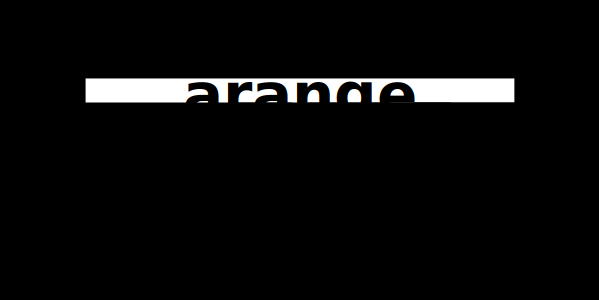

In [22]:
draw_examples("arange", [{"": arange(i)} for i in [1, 3]])

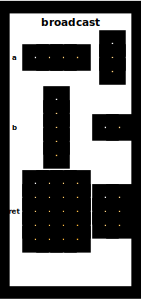

In [63]:
examples = [
    (arange(4), arange(5)[:,None]), 
            (arange(3)[:,None], arange(2))
]
draw_examples("broadcast", [{f"a": a, "b": b, "ret": a+b} for i,(a,b) in enumerate(examples)])

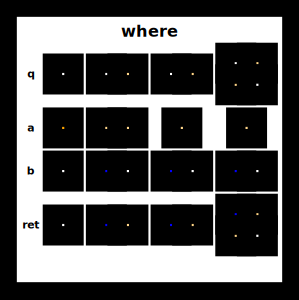

In [75]:
def where(q, a, b):
    return (q * a) + (~q) * b


examples = [
    (tensor([False]), tensor([10]), tensor([0])),
    (tensor([False, True]), tensor([1, 1]), tensor([-10, 0])),
    (tensor([False, True]), tensor([1]), tensor([-10, 0])),
    (tensor([[False, True], [True, False]]), tensor([1]), tensor([-10, 0]) )
]
draw_examples("where", [{'q': q, 'a': a, 'b': b, 'ret': where(q, a, b)} for q,a,b in examples])

1) ones

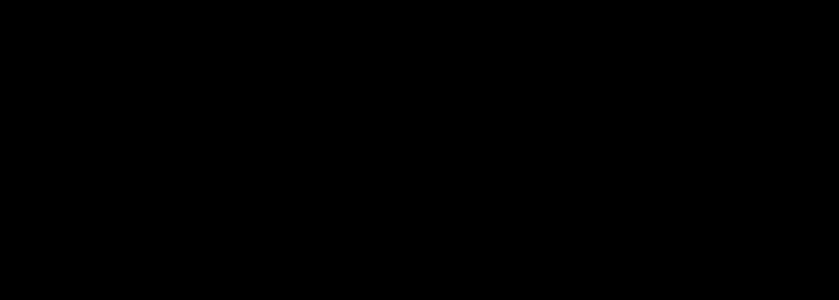

In [123]:
def ones_spec(out):
    for i in range(len(out)):
        out[i] = 1
        
# def ones(i: int) -> TT["i"]:
#     return arange(i) - arange(i) + 1

def ones(i: int) -> TT["i"]:
    return where(arange(i) > -1, 1, 0)

test_ones = make_test("one", ones, ones_spec, add_sizes=["i"])

In [127]:
run_test(test_ones)

Correct!


2) sum

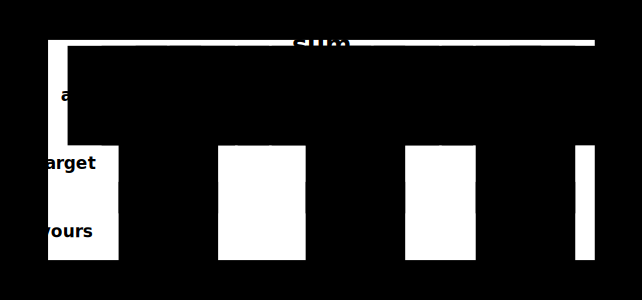

In [129]:
def sum_spec(a, out):
    out[0] = 0
    for i in range(len(a)):
        out[0] += a[i]
        
def sum(a: TT["i"]) -> TT[1]:
    return ones(a.shape[0]) @ a[:,None]

test_sum = make_test("sum", sum, sum_spec)

In [131]:
run_test(test_sum)

Correct!


3) outer

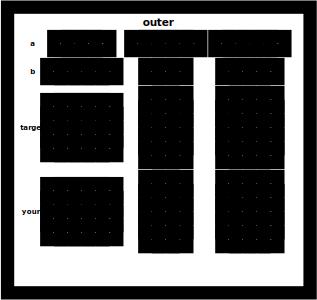

In [160]:
def outer_spec(a, b, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            out[i][j] = a[i] * b[j]
            
def outer(a: TT["i"], b: TT["j"]) -> TT["i", "j"]:
    return a[:,None] @ b[None]
     
test_outer = make_test("outer", outer, outer_spec)

In [161]:
run_test(test_outer)

Correct!


In [162]:
a = torch.randn(3)
b = torch.randn(2)
o1 = a.view(3, 1) @ b.view(1, 2)

o2 = torch.outer(a, b)
torch.allclose(o1, o2)
print(o2.shape)

torch.Size([3, 2])


4) diag

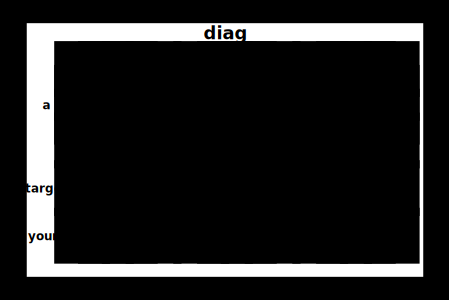

In [187]:
def diag_spec(a, out):
    for i in range(len(a)):
        out[i] = a[i][i]
        
def diag(a: TT["i", "i"]) -> TT["i"]:
    return a[arange(a.shape[0]), arange(a.shape[0])]

   
test_diag = make_test("diag", diag, diag_spec)

In [188]:
run_test(test_diag)

Correct!


5) eye

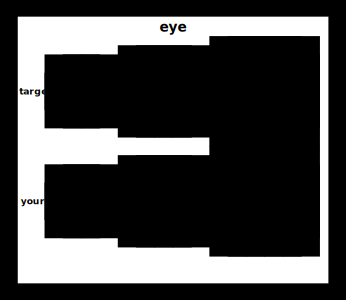

In [199]:
def eye_spec(out):
    for i in range(len(out)):
        out[i][i] = 1
        
def eye(j: int) -> TT["j", "j"]:
    return 1* (arange(j)[:,None] == arange(j))
#     return where(arange(j)[:,None] == arange(j), 1, 0)
    
test_eye = make_test("eye", eye, eye_spec, add_sizes=["j"])

In [200]:
run_test(test_eye)

Correct!


6) triu

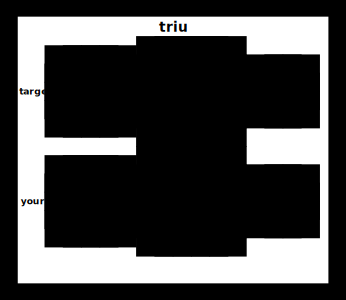

In [207]:
def triu_spec(out):
    for i in range(len(out)):
        for j in range(len(out)):
            if i <= j:
                out[i][j] = 1
            else:
                out[i][j] = 0
                
def triu(j: int) -> TT["j", "j"]:
    return 1*(arange(j)[:,None] <= arange(j))


test_triu = make_test("triu", triu, triu_spec, add_sizes=["j"])

In [209]:
run_test(test_triu)

Correct!


7) cumsum

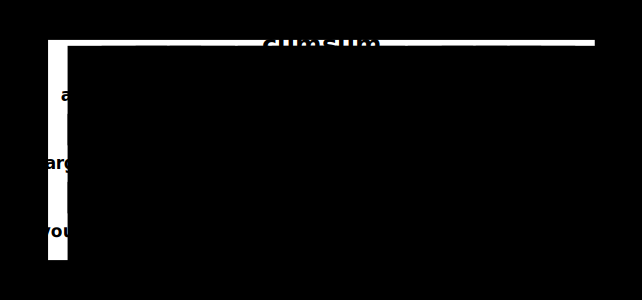

In [246]:
def cumsum_spec(a, out):
    total = 0
    for i in range(len(out)):
        out[i] = total + a[i]
        total += a[i]

def cumsum(a: TT["i"]) -> TT["i"]:
    i = len(a)
#     return a @ (1*(arange(i)[:,None] <= arange(i)[None]))
    return a @ where(arange(i)[:,None] <= arange(i), 1, 0)

test_cumsum = make_test("cumsum", cumsum, cumsum_spec)

In [244]:
run_test(test_cumsum)

Correct!


8) diff

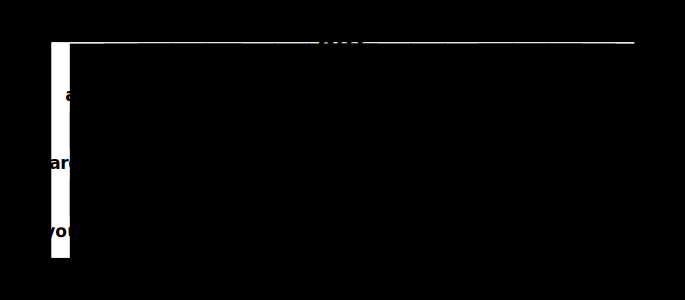

In [250]:
def diff_spec(a, out):
    out[0] = a[0]
    for i in range(1, len(out)):
        out[i] = a[i] - a[i - 1]

def diff(a: TT["i"], i: int) -> TT["i"]:
    return a - where(arange(i)>0, a[arange(i)-1], 0)

test_diff = make_test("diff", diff, diff_spec, add_sizes=["i"])

In [251]:
run_test(test_diff)

Correct!


9) vstack

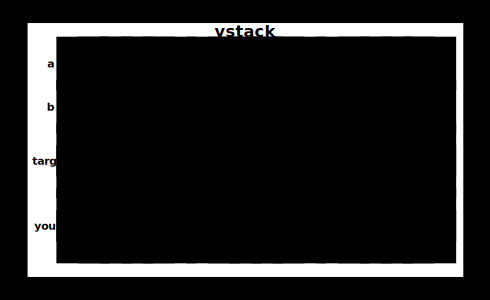

In [266]:
def vstack_spec(a, b, out):
    for i in range(len(out[0])):
        out[0][i] = a[i]
        out[1][i] = b[i]

def vstack(a: TT["i"], b: TT["i"]) -> TT[2, "i"]:
    i = a.shape[0]
    return where(arange(2)[:,None] == ones(i), b, a)

test_vstack = make_test("vstack", vstack, vstack_spec)

In [267]:
run_test(test_vstack)

Correct!


10) roll

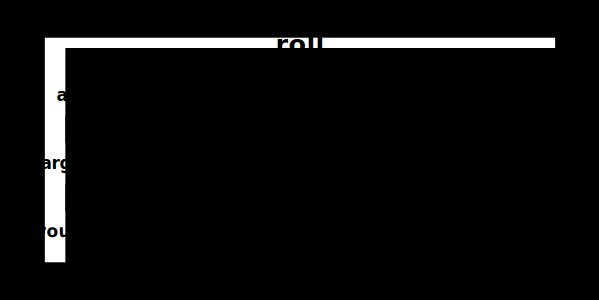

In [300]:
def roll_spec(a, out):
    for i in range(len(out)):
        if i + 1 < len(out):
            out[i] = a[i + 1]
        else:
            out[i] = a[i + 1 - len(out)]
            
def roll(a: TT["i"], i: int) -> TT["i"]:
    return a[(arange(i)+1)%i]

test_roll = make_test("roll", roll, roll_spec, add_sizes=["i"])

In [301]:
run_test(test_roll)

Correct!


11) flip

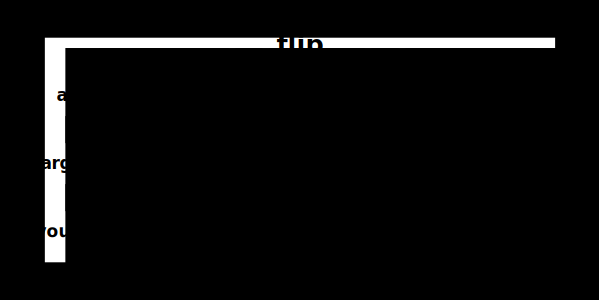

In [316]:
def flip_spec(a, out):
    for i in range(len(out)):
        out[i] = a[len(out) - i - 1]
        
def flip(a: TT["i"], i: int) -> TT["i"]:
    return a[(arange(i) - i)*-1-1]

test_flip = make_test("flip", flip, flip_spec, add_sizes=["i"])

In [318]:
run_test(test_flip)

Correct!


12) compress

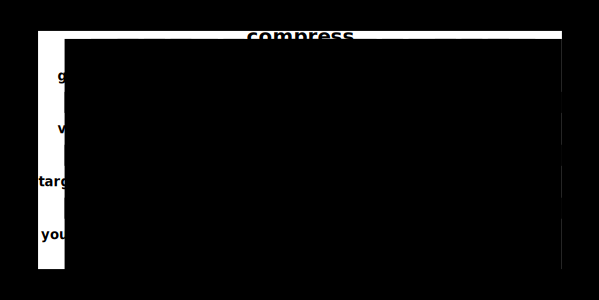

In [390]:
def compress_spec(g, v, out):
    j = 0
    for i in range(len(g)):
        if g[i]:
            out[j] = v[i]
            j += 1
    
      
def compress(g: TT["i", bool], v: TT["i"], i:int) -> TT["i"]:
    return v @ where(g[:,None], arange(i)==(cumsum(g*1)-1)[:,None], 0)


test_compress = make_test("compress", compress, compress_spec, add_sizes=["i"])

In [391]:
run_test(test_compress)

Correct!


13) pad_to

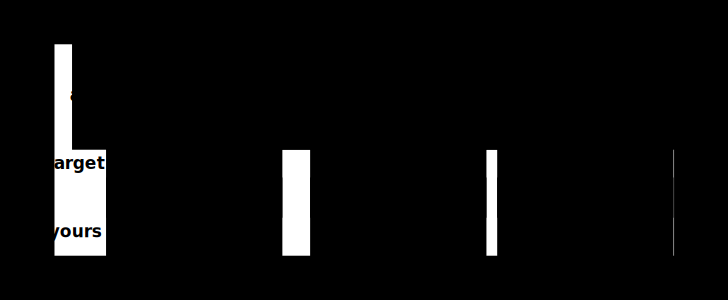

In [421]:
def pad_to_spec(a, out):
    for i in range(min(len(out), len(a))):
        out[i] = a[i]


def pad_to(a: TT["i"], i: int, j: int) -> TT["j"]:
    return a @ (1 *(arange(i)[:,None]==arange(j)))


test_pad_to = make_test("pad_to", pad_to, pad_to_spec, add_sizes=["i", "j"])

In [422]:
run_test(test_pad_to)

Correct!


14) sequence_mask

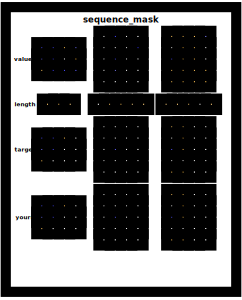

In [448]:
def sequence_mask_spec(values, length, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            if j < length[i]:
                out[i][j] = values[i][j]
            else:
                out[i][j] = 0
    
def sequence_mask(values: TT["i", "j"], length: TT["i", int]) -> TT["i", "j"]:
    i,j = values.shape
    return where(length[:,None] > arange(j), values, 0)


def constraint_set_length(d):
    d["length"] = d["length"] % d["values"].shape[1]
    return d


test_sequence = make_test("sequence_mask",
    sequence_mask, sequence_mask_spec, constraint=constraint_set_length
)

In [449]:
run_test(test_sequence)

Correct!


15) bincount

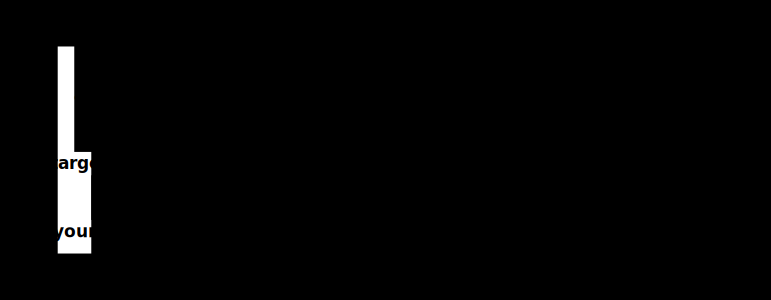

In [477]:
def bincount_spec(a, out):
    for i in range(len(a)):
        out[a[i]] += 1
        
def bincount(a: TT["i"], j: int) -> TT["j"]:
    return ones(a.shape[0])@eye(j)[a]


def constraint_set_max(d):
    d["a"] = d["a"] % d["return"].shape[0]
    return d


test_bincount = make_test("bincount",
    bincount, bincount_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [478]:
run_test(test_bincount)

Correct!


16) scatter_add

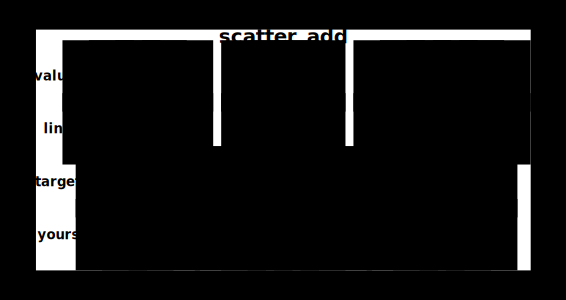

In [490]:
def scatter_add_spec(values, link, out):
    for j in range(len(values)):
        out[link[j]] += values[j]
        
def scatter_add(values: TT["i"], link: TT["i"], j: int) -> TT["j"]:
    return values @((link[:,None] == arange(j))*1)


def constraint_set_max(d):
    d["link"] = d["link"] % d["return"].shape[0]
    return d


test_scatter_add = make_test("scatter_add",
    scatter_add, scatter_add_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [491]:
run_test(test_scatter_add)

Correct!


17) flatten

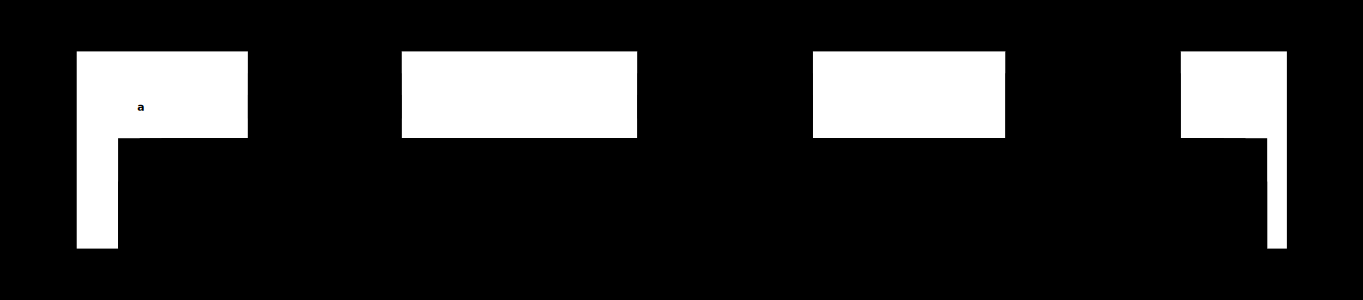

In [529]:
def flatten_spec(a, out):
    k = 0
    for i in range(len(a)):
        for j in range(len(a[0])):
            out[k] = a[i][j]
            k += 1

def flatten(a: TT["i", "j"], i:int, j:int) -> TT["i * j"]:
    return a[arange(i*j)//j, arange(i*j)%j]

test_flatten = make_test("flatten", flatten, flatten_spec, add_sizes=["i", "j"])

In [531]:
run_test(test_flatten)

Correct!
